In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

## 数据准备

In [8]:
hitters_df = pd.read_csv('Hitters.csv')
hitters_df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


We see that Salary is missing for 59 players. The dropna() function removes all of the rows that have missing values in any variable:

In [12]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 20)
Dimensions of modified data: (263, 20)
Number of null values: 0


Some of our predictors are categorical, so we'll want to clean those up as well. We'll ask pandas to generate dummy variables for them, separate out the response variable, and stick everything back together again:

In [13]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

## 模型建立

In [15]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [17]:
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a DataFrame containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors  k :

In [18]:
# Could take quite awhile to complete...
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.07487893104553223 seconds.
Processed 171 models on 2 predictors in 0.5231480598449707 seconds.
Processed 969 models on 3 predictors in 2.324787139892578 seconds.
Processed 3876 models on 4 predictors in 8.772018909454346 seconds.
Processed 11628 models on 5 predictors in 27.86030602455139 seconds.
Processed 27132 models on 6 predictors in 64.49843001365662 seconds.
Processed 50388 models on 7 predictors in 136.6744499206543 seconds.
Total elapsed time: 242.383939743042 seconds.


In [19]:
models_best

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...


在第二个模型的时候 RSS有较大的下滑 所以选取第二个

In [40]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                    5.80e-82
Time:                        17:27:20   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.007874011993408203 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                    1.31e-76
Time:                        17:19:59   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P

In [24]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [25]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

As expected, the  R2  statistic increases monotonically as more variables are included.

Plotting RSS, adjusted  R2 , AIC, and BIC for all of the models at once will help us decide which model to select. Note the type="l" option tells R to connect the plotted points with lines:

Text(0, 0.5, 'BIC')

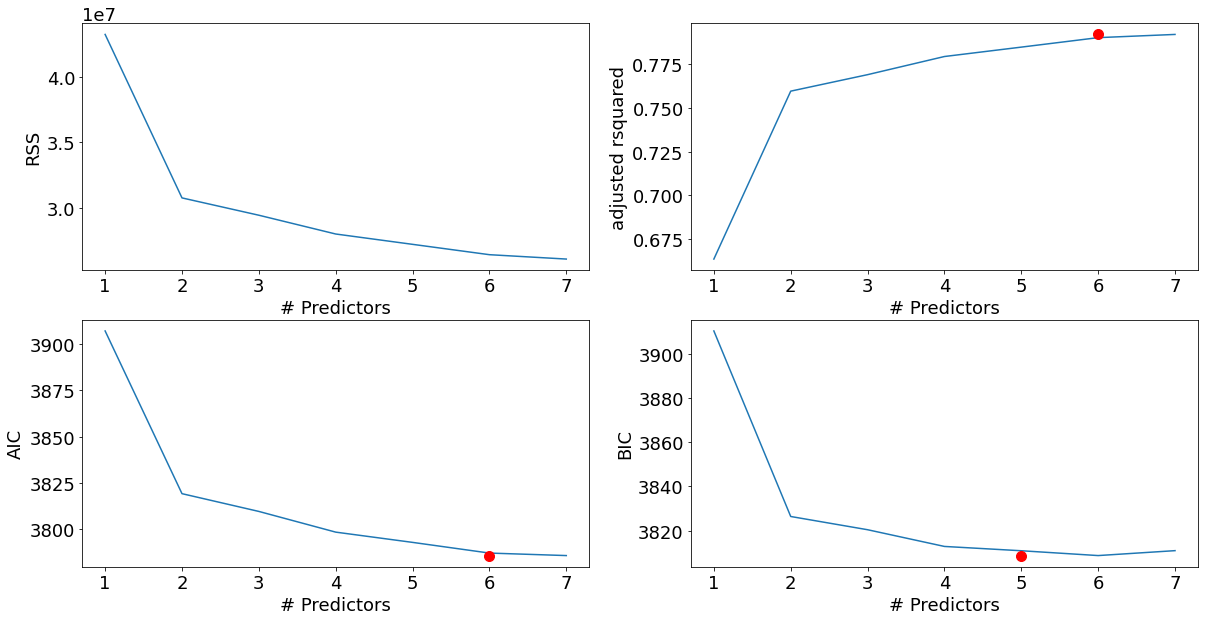

In [26]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

## Forward Stepwise Selection

In [27]:
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [28]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []
for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.06437492370605469 seconds.
Processed  18 models on 2 predictors in 0.06843805313110352 seconds.
Processed  17 models on 3 predictors in 0.0862112045288086 seconds.
Processed  16 models on 4 predictors in 0.11349701881408691 seconds.
Processed  15 models on 5 predictors in 0.060559988021850586 seconds.
Processed  14 models on 6 predictors in 0.07260680198669434 seconds.
Processed  13 models on 7 predictors in 0.04808807373046875 seconds.
Processed  12 models on 8 predictors in 0.05929899215698242 seconds.
Processed  11 models on 9 predictors in 0.04437685012817383 seconds.
Processed  10 models on 10 predictors in 0.02856922149658203 seconds.
Processed  9 models on 11 predictors in 0.02982783317565918 seconds.
Processed  8 models on 12 predictors in 0.025074005126953125 seconds.
Processed  7 models on 13 predictors in 0.02362823486328125 seconds.
Processed  6 models on 14 predictors in 0.023416996002197266 seconds.
Processed  5 models on 15 predi

In [34]:
print(models_best.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                    1.79e-85
Time:                        17:23:49   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [35]:
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                    1.79e-85
Time:                        17:23:54   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Backward Selection

In [36]:
def backward(predictors):
    
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [37]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))
tic = time.time()
predictors = X.columns
while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.07580804824829102 seconds.
Processed  18 models on 17 predictors in 0.07420587539672852 seconds.
Processed  17 models on 16 predictors in 0.11764383316040039 seconds.
Processed  16 models on 15 predictors in 0.076416015625 seconds.
Processed  15 models on 14 predictors in 0.10026407241821289 seconds.
Processed  14 models on 13 predictors in 0.07863616943359375 seconds.
Processed  13 models on 12 predictors in 0.05049419403076172 seconds.
Processed  12 models on 11 predictors in 0.046946048736572266 seconds.
Processed  11 models on 10 predictors in 0.03211617469787598 seconds.
Processed  10 models on 9 predictors in 0.03177809715270996 seconds.
Processed  9 models on 8 predictors in 0.024008989334106445 seconds.
Processed  8 models on 7 predictors in 0.027517318725585938 seconds.
Processed  7 models on 6 predictors in 0.025786876678466797 seconds.
Processed  6 models on 5 predictors in 0.022984027862548828 seconds.
Processed  5 models on 4 pred

In [38]:
print(models_bwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.787
Method:                 Least Squares   F-statistic:                              162.9
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                    1.37e-84
Time:                        17:25:27   Log-Likelihood:                         -1889.7
No. Observations:                 263   AIC:                                      3791.
Df Residuals:                     257   BIC:                                      3813.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For this data, the best one-variable through six-variable models are each identical for best subset and forward selection. However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different:

In [42]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [43]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [44]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64
